In [1]:
from math import sqrt
import time

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, preprocessing, model_selection
from sklearn.metrics import mean_squared_error
# импортируем необходимый класс из модуля preprocessing библиотеки sklearn
from sklearn.preprocessing import StandardScaler

from activation import fun_dict


In [2]:
def load_dataset():
    
    ''' Загрузка датасета и предобработка данных '''

    x, y = datasets.load_breast_cancer(return_X_y=True)
    x = preprocessing.scale(x)
    y = y.reshape(len(y), 1)
    x_path = 'dat/cancer/'
    return x, y

def rmse(a, b):

    ''' Расчет среднеквадратичного отклонения '''

    return sqrt(mean_squared_error(a, b)) 


In [3]:
class NeuralNetwork:
    """
    Neural Network.
    """
    dim: int  # Dimension of the data (features)
    t: int  # Dimension of the target (labels)
    max_iter: int  # Number of iterations
    neurons: int  # Number of neurons in the input layer
    learning_rate: float  # Step
    # Matrix
    input_weight: np.array
    output_weight: np.array
    bias_input_layer: np.array
    bias_output_layer: np.array
    temp_h: np.array  # Value of the hidden layer before applying activation.
    temp_o: np.array  # Value of the output layer before applying activation.
    # Neuronal functions
    activation = None
    activation_der = None

    def __init__(self, seed=None):
        """
        Fix the random number generator.
        """
        np.random.seed(seed)

    def get_layers(self):
        """
        Feed forward random assignation of the two layers.
        """
        self.get_input_layer()
        self.get_output_layer()

    def get_input_layer(self):
        """
        Weights and bias for the hidden layer.
        """
        self.input_weight = np.random.random((self.dim,
                                              self.neurons)) * 2.0 - 1.0
        # self.bias_input_layer = np.random.random((self.neurons, 1))
        self.bias_input_layer = np.zeros((self.neurons, 1))

    def get_output_layer(self):
        """
        Weight and bias for the output layer.
        """
        self.output_weight = np.random.random((self.neurons, 1))  * 2.0 - 1.0
        # self.bias_output_layer = np.random.random((self.t, 1))
        self.bias_output_layer = np.zeros((self.t, 1))
    def initial(self, x, y,
                max_iter,
                neurons,
                learning_rate,
                neuronal_fun):
        """
        Initialize the neural network layers.
        :param x: numpy.array with data (intances and features).
        :param y: numpy.array with the target to predict.
        :param int max_iter: number of iterations for training.
        :param int neurons: number of neurons in the hidden layer.
        :param float learning_rate: step to add in each iteration.
        :param str neuronal_fun: function for activation functions in 
        """
        self.dim = x.shape[1]
        self.t = y.shape[1]
        self.max_iter = max_iter
        self.neurons = neurons
        self.learning_rate = learning_rate
        self.activation = fun_dict[neuronal_fun]['activation']
        self.activation_der = fun_dict[neuronal_fun]['derivative']
        self.get_layers()
        return self

    def train(self, x, y,
              max_iter: int = 1000,
              neurons: int = 10,
              learning_rate: float = 1.0,
              neuronal_fun='sigmoid'):
        """
        Train the neural network with gradient descent.
        :param x: numpy.array with data (intances and features).
        :param y: numpy.array with the target to predict.
        :param int max_iter: number of iterations for training.
        :param int neurons: number of neurons in the hidden layer.
        :param float learning_rate: step to add in each iteration.
        :param str neuronal_fun: function for activation functions in 
        """
        self.initial(x=x,
                     y=y,
                     max_iter=max_iter,
                     neurons=neurons,
                     learning_rate=learning_rate,
                     neuronal_fun=neuronal_fun)

        for iteration in range(self.max_iter):
            # print('Iteration =', iteration)
            self.backward(x, y)

    def backward(self, x, y, penalty):
        """
        Back propagation formula with a penalty.
        :param x:
        :param y:
        :param penalty:
        :return:
        """
        hidden_layer, output_layer = self.forward(x)
        error = output_layer - y
        # print('Error =', np.linalg.norm(error), ', NC penalty =', np.linalg.norm(penalty))
        nc_error = error + penalty

        # Output layer
        output_delta = nc_error * self.activation_der(self.temp_o)
        # print('Norm of the gradient of output layer =', np.linalg.norm(output_delta))
        self.bias_output_layer -= np.mean(self.learning_rate * output_delta)
        self.output_weight -= self.learning_rate * np.dot(hidden_layer.T, output_delta)

        # Hidden layer
        hidden_delta = np.dot(output_delta, self.output_weight.T) * self.activation_der(self.temp_h)
        # print('Norm of the gradient of hidden layer =', np.linalg.norm(hidden_delta))
        self.bias_input_layer -= np.mean(self.learning_rate * hidden_delta, axis=0).reshape(self.neurons, 1)
        self.input_weight -= self.learning_rate * np.dot(x.T, hidden_delta)

    def forward(self, x_test):
        self.temp_h = np.dot(x_test, self.input_weight) + self.bias_input_layer.T
        hidden_layer = self.activation(self.temp_h)
        self.temp_o = np.dot(hidden_layer, self.output_weight) + self.bias_output_layer.T
        output_layer = self.activation(self.temp_o)
        return hidden_layer, output_layer


    def predict(self, x_test):
        _, output_layer = self.forward(x_test)
        return output_layer

class NCL:
    
    ''' Negative Correlation Learning ensemble '''

    size: int
    max_iter: int
    lambda_: float
    learning_rate: float
    base_learner = list
    rmse_array: np.array

    def train(self, x, y, size, neurons, max_iter, lambda_, learning_rate, neural_fun='sigmoid'):
        
        '''
        Обучение ансамбля
        - параметр x: данные
        - параметр y: метка
        - параметр size: кол-во обучаемых моделей
        - параметр neurons: кол-во нейронов
        - параметр max_iter: кол-во эпох
        - параметр lambda_: 
        - параметр learning_rate: скорость обучения
        - параметр neural_fun: функция активации
        '''

        # Parameter
        self.size = size
        self.max_iter = max_iter
        self.lambda_ = lambda_
        self.base_learner = [NeuralNetwork(seed=s).initial(x=x,
                                                           y=y,
                                                           neurons=neurons,
                                                           learning_rate=learning_rate,
                                                           neuronal_fun=neural_fun,
                                                           max_iter=max_iter)
                             for s in range(self.size)]
        
        # Saving RMSE in training
        self.rmse_array = np.inf * np.ones(self.max_iter)
        weights = []

        # Обучение
        for iteration in range(self.max_iter):  # Each epoch
            #print('Iteration =', iteration)
            f_bar = self.predict(x)
            for s in range(self.size):  # Each base learner
                penalty = - self.lambda_ * (self.base_learner[s].predict(x) - f_bar)
                self.base_learner[s].backward(x, y, penalty)
                # print()
            # print()
            self.rmse_array[iteration] = rmse(f_bar, y)
        
        for i in range(len(self.base_learner)):
            weights.append(self.base_learner[i].input_weight)
            weights.append(self.base_learner[i].output_weight)
            weights.append(self.base_learner[i].bias_input_layer)
            weights.append(self.base_learner[i].bias_output_layer)

        MyFile=open('weights.txt', 'w+')
        for element in weights:
            MyFile.write(str(element))
            MyFile.write('\n')
        MyFile.close()
            
    def predict(self, x):
        """
        :param x:
        :return: f_bar
        """
        f_bar = np.mean([self.base_learner[s].predict(x) for s in range(self.size)],
                        axis=0)
        return f_bar

Train =  341
Test =  228
Colums =  30
Lambda =  0
RMSE = 0.3000592981861786
Время обучения = 6.894188500009477
Время отклика = 0.00043739998363889754


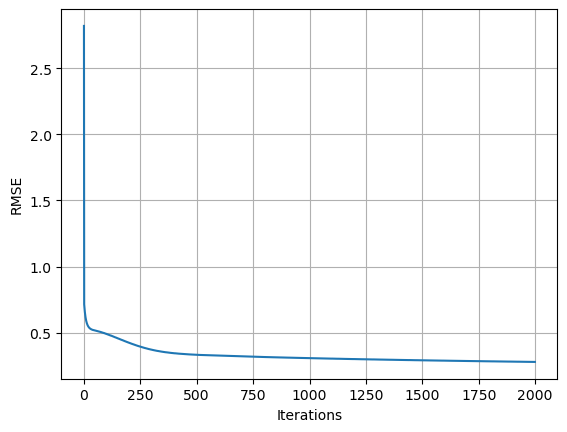

In [4]:

# Загрузка датасета и формирование выборок
x, y = load_dataset()
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size= 0.4, random_state=0)
print('Train = ',  x_train.shape[0])
print('Test = ',   x_test.shape[0])
print('Colums = ', x_train.shape[1])

# Параметры обучения
max_iter = 2000
size = 10
h = 15                  # Количество нейронов в скрытом слое
lambda_ = 0
learning_rate = 0.001   # Скорость обучения
print('Lambda = ', lambda_)

# Создание ансамбля моделей
model = NCL()

# Обучение
train_time_start = time.perf_counter()
model.train(x_train, y_train, size, h, max_iter, lambda_, learning_rate, neural_fun='leaky_relu')
train_time_end = time.perf_counter()

# Тестирование
test_time_start = time.perf_counter()
pred = model.predict(x_test)
test_time_end = time.perf_counter()

# RMSE
rmse_value = rmse(pred, y_test)
print('RMSE =', rmse_value)

# Время обучения
print('Время обучения =', train_time_end - train_time_start)
print('Время отклика =', test_time_end - test_time_start)

# Кривая обучения 
plt.plot(model.rmse_array)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.grid()
plt.show()